In [23]:
import os
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow import keras
from numba import cuda

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, f1_score

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import gc

print("Loading Libraries Done")

Loading Libraries Done


In [2]:

main_folder = "./Diabetic_Dataset"
RANDOM_SEED = 6

categories = os.listdir(main_folder)
try:
    categories.remove(".DS_Store")
except:
    pass
print(categories, len(categories))



['0', '1', '2', '3', '4'] 5


In [3]:
TOTAL_CATEGORIES = len(categories)
IMAGE_SIZE = (224,224,3)

def load_images_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        print(index, category)
        for image_name in tqdm(os.listdir(main_folder+"/"+category)):
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg"):
              try:
                    imgname = main_folder+"/"+category+"/"+image_name
                    imgname = imgname.replace("//", "/")
                    img = cv2.imread(imgname)
                    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # img_rotated_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                    # img_rotated_180 = cv2.rotate(img, cv2.ROTATE_180)
                    # img_rotated_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                    # img_flip_ver = cv2.flip(img, 0)
                    # img_flip_hor = cv2.flip(img, 1)

                    img_array = Image.fromarray(img, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    # img_array = Image.fromarray(img_rotated_90, 'RGB')
                    # img_lst.append(np.array(img_array))
                    # labels.append(index)

                    # img_array = Image.fromarray(img_rotated_180, 'RGB')
                    # img_lst.append(np.array(img_array))
                    # labels.append(index)

                    # img_array = Image.fromarray(img_rotated_270, 'RGB')
                    # img_lst.append(np.array(img_array))
                    # labels.append(index)

                    # img_array = Image.fromarray(img_flip_ver, 'RGB')
                    # img_lst.append(np.array(img_array))
                    # labels.append(index)

                    # img_array = Image.fromarray(img_flip_hor, 'RGB')
                    # img_lst.append(np.array(img_array))
                    # labels.append(index)

              except:
                    print(imgname)
                    print(img)
                

    return img_lst, labels

images, labels = load_images_labels(categories)
print()
print("Total Images Loaded:", len(images))

0 0


100%|██████████| 6266/6266 [02:30<00:00, 41.75it/s] 


1 1


100%|██████████| 630/630 [00:11<00:00, 57.20it/s] 


2 2


100%|██████████| 4477/4477 [01:22<00:00, 54.17it/s] 


3 3


100%|██████████| 236/236 [00:03<00:00, 59.31it/s]


4 4


100%|██████████| 913/913 [00:26<00:00, 34.74it/s]


Total Images Loaded: 12522


In [4]:
images = np.array(images)
labels = np.array(labels)

In [5]:
np.random.seed(RANDOM_SEED)

n = np.arange(images.shape[0])
np.random.shuffle(n)

images = images[n]
labels = labels[n]

In [6]:
images = images.astype(np.float32)
labels = labels.astype(np.int8)
images /= 255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (12522, 224, 224, 3)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = RANDOM_SEED)


print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (10017, 224, 224, 3)
y_train shape =  (10017,)

x_test shape =  (2505, 224, 224, 3)
y_test shape =  (2505,)


In [8]:
del(images)
del(labels)

In [9]:
EPOCHS = 20
BATCH_SIZE = 32

Resent 152 v2 Model


In [10]:
resnet_152_v2 = ResNet152V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [11]:
#do not train the pre-trained layers
for layer in resnet_152_v2.layers:
    layer.trainable = False

In [12]:
x = Flatten()(resnet_152_v2.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_152_v2_model = Model(inputs=resnet_152_v2.input, outputs=prediction)
# view the structure of the model
resnet_152_v2_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [13]:
resnet_152_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])

In [14]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=10, restore_best_weights=True)

In [15]:
# fit the model
resnet_152_v2_history = resnet_152_v2_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch = BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/20
32/32 [==============================] - 713s 22s/step - loss: 1.7716 - acc: 0.3838 - val_loss: 1.7923 - val_acc: 0.4291
Epoch 2/20
32/32 [==============================] - 694s 22s/step - loss: 1.4172 - acc: 0.5059 - val_loss: 1.3468 - val_acc: 0.5276
Epoch 3/20
32/32 [==============================] - 687s 22s/step - loss: 1.3502 - acc: 0.5488 - val_loss: 1.1976 - val_acc: 0.5974
Epoch 4/20
32/32 [==============================] - 726s 23s/step - loss: 1.2071 - acc: 0.5664 - val_loss: 1.1456 - val_acc: 0.6410
Epoch 5/20
32/32 [==============================] - 789s 25s/step - loss: 1.1965 - acc: 0.5840 - val_loss: 1.0427 - val_acc: 0.6739
Epoch 6/20
32/32 [==============================] - 803s 26s/step - loss: 1.0791 - acc: 0.6152 - val_loss: 0.9942 - val_acc: 0.6575
Epoch 7/20
32/32 [==============================] - 788s 25s/step - loss: 1.0441 - acc: 0.6279 - val_loss: 0.9096 - val_acc: 0.6791
Epoch 8/20
32/32 [==============================] - 707s 23s/step - loss: 1.

In [16]:
resnet_152_v2_loss,resnet_152_v2_acc = resnet_152_v2_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_152_V2 Loss:", resnet_152_v2_loss)
print("Resnet_152_V2 Accuracy:", resnet_152_v2_acc*100, "%")

79/79 [==============================] - 500s 6s/step - loss: 0.7748 - acc: 0.7078
Resnet_152_V2 Loss: 0.7747623324394226
Resnet_152_V2 Accuracy: 70.77844142913818 %


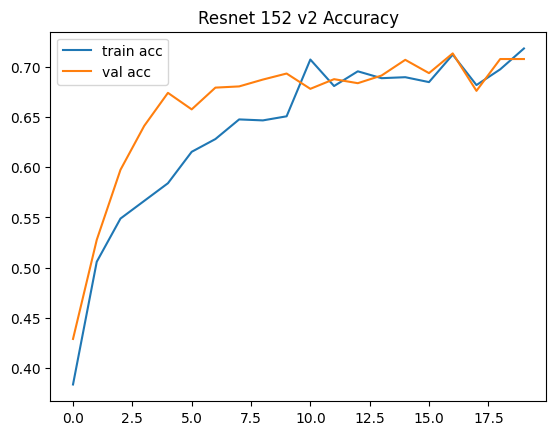

In [17]:
# accuracies
plt.plot(resnet_152_v2_history.history['acc'], label='train acc')
plt.plot(resnet_152_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 152 v2 Accuracy")
plt.legend()
plt.show()

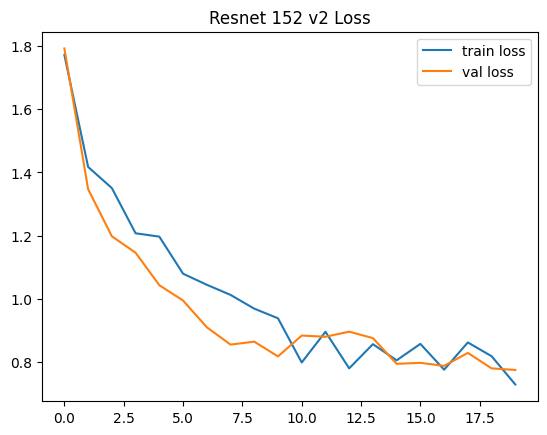

In [18]:
# loss
plt.plot(resnet_152_v2_history.history['loss'], label='train loss')
plt.plot(resnet_152_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 152 v2 Loss")
plt.legend()
plt.show()

In [21]:
#predict
y_pred=resnet_152_v2_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

79/79 [==============================] - 559s 7s/step
              precision    recall  f1-score   support

           0       0.78      0.81      0.80      1212
           1       0.00      0.00      0.00         0
           2       0.78      0.60      0.68      1168
           3       0.00      0.00      0.00         0
           4       0.50      0.70      0.58       125

    accuracy                           0.71      2505
   macro avg       0.41      0.42      0.41      2505
weighted avg       0.77      0.71      0.73      2505



c:\Users\preet\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\preet\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\preet\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [24]:
print(confusion_matrix(y_pred,y_test))#get confusion matrix

resnet_152_v2_model.save("./diabetic_retinopathy_resnet_152v2_model.h5", save_format="h5")

[[983  49 170   2   8]
 [  0   0   0   0   0]
 [267  82 702  37  80]
 [  0   0   0   0   0]
 [  4   1  24   8  88]]
